## 0. Import thư viện

In [1]:
from datasets import load_dataset
from PIL import Image
import re
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
from torchvision import transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

from transformers import AutoProcessor, BlipForConditionalGeneration
from tqdm import tqdm

import nltk
from nltk.translate.bleu_score import corpus_bleu

/home/khahao/venv_hao/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-04 08:21:15.645235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 08:21:15.986862: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 08:21:17.570024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different n

## 1. Tải Dataset Flickr8k từ Hugging Face

In [2]:
ds = load_dataset("jxie/flickr8k")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
})


## 2. Tiền xử lý Captions

In [3]:
def clean_caption(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9' ]+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [4]:
def flatten_dataset(split):
    items = []
    for row in tqdm(ds[split], desc=f"Flatten {split}"):
        for i in range(5):
            items.append({
                "image": row["image"],
                "caption": clean_caption(row[f"caption_{i}"])
            })
    return items

train_clean = flatten_dataset("train")
val_clean   = flatten_dataset("validation")
test_clean  = flatten_dataset("test")

Flatten test: 100%|██████████| 1000/1000 [00:01<00:00, 601.19it/s]


In [5]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

tokenizer = processor.tokenizer

max_len = 0
for item in train_clean:
    tokens = tokenizer(
        item["caption"],
        add_special_tokens=True  
    ).input_ids
    max_len = max(max_len, len(tokens))

print("Max token length =", max_len)

flickr_vocab = set()
for item in train_clean:   
    ids = tokenizer(item["caption"], add_special_tokens=False).input_ids
    flickr_vocab.update(ids)
flickr_vocab = sorted(list(flickr_vocab))
eos_id = processor.tokenizer.sep_token_id

print(f"Flickr8k vocab size: {len(flickr_vocab)}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Max token length = 41
Flickr8k vocab size: 6719


In [6]:
from transformers.generation.logits_process import LogitsProcessor

class FlickrVocabLogitsProcessor(LogitsProcessor):
    def __init__(self, vocab_ids, eos_id):
        self.vocab_ids = sorted(list(vocab_ids) + [eos_id])  # đảm bảo eos_id luôn được phép

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        # scores: [batch_size, vocab_size]
        mask = torch.full_like(scores, float('-inf'))  
        mask[:, self.vocab_ids] = 0                   
        return scores + mask

flickr_logits_processor = FlickrVocabLogitsProcessor(flickr_vocab, eos_id)

## 3. Tiền xử lý Image

In [7]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.RandomResizedCrop((384, 384), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.RandomGrayscale(p=0.1)
])

# No augmentation for validation/test
val_transform = transforms.Resize((384, 384))

## 4. Data Generator

In [8]:
from torch.utils.data import Dataset
from PIL import Image

class Flickr8kDataset(Dataset):
    def __init__(self, data_list, processor, max_len=32, transform=None):
        self.data = data_list
        self.processor = processor
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = item["image"]
        if self.transform:
            img = self.transform(img)

        cap = item["caption"]

        encoding = self.processor(
            images=img,
            text=cap,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        pixel_values = encoding["pixel_values"].squeeze(0)
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }


In [9]:
# Apply different transforms for train and validation
train_dataset = Flickr8kDataset(train_clean, processor, transform=train_transform)
val_dataset   = Flickr8kDataset(val_clean, processor, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)

## 5. Build model và training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [ ]:
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

decoder_layers = list(model.text_decoder.bert.encoder.layer)
num_layers = len(decoder_layers)

print(f"Tổng số layers trong text decoder: {num_layers}")
print(f"Mở layers: {num_layers-3} đến {num_layers-1}")

# Freeze toàn bộ vision model
for param in model.vision_model.parameters():
    param.requires_grad = False

# Freeze toàn bộ text decoder trước
for param in model.text_decoder.parameters():
    param.requires_grad = False

for i in range(max(0, num_layers-2), num_layers):
    layer = decoder_layers[i]
    for param in layer.parameters():
        param.requires_grad = True

total_params = 0
trainable_params = 0


for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print(f"  • Tổng tham số: {total_params:,}")
print(f"  • Tham số trainable: {trainable_params:,}")
print(f"  • Tỷ lệ trainable: {100 * trainable_params / total_params:.2f}%")

Tổng số layers trong text decoder: 12
Mở layers: 9 đến 11
  ✅ Layer 10 - UNFROZEN
  ✅ Layer 11 - UNFROZEN
  • Tổng tham số: 223,971,644
  • Tham số trainable: 18,903,552
  • Tỷ lệ trainable: 8.44%


## 6. Setup Training và config

In [4]:
output_dir = "./checkpoints"
os.makedirs(output_dir, exist_ok=True)

# Simple checkpoint functions
def save_checkpoint(epoch, model, optimizer, train_loss, val_loss, best_val_loss, patience_counter):
    """Save training checkpoint"""
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }
    
    torch.save(checkpoint, os.path.join(output_dir, "checkpoint_latest.pth"))
    print(f"Checkpoint saved at epoch {epoch+1}")

def load_checkpoint(model, optimizer):

    checkpoint_path = os.path.join(output_dir, "checkpoint_latest.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint
    return None

def update_training_info(train_losses, val_losses, best_val_loss, current_epoch):

    training_info = {
        "best_val_loss": float(best_val_loss),
        "current_epoch": current_epoch + 1,
        "total_epochs": len(train_losses),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "last_updated": datetime.now().isoformat()
    }
    
    with open(os.path.join(output_dir, "training_info.json"), "w") as f:
        json.dump(training_info, f, indent=2)

In [13]:
# Simplified Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training parameters
num_epochs = 20
patience = 5

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad], 
    lr=1e-4, 
    weight_decay=0.01,
    eps=1e-8, 
    betas=(0.9, 0.999)  
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience)

# Training state
start_epoch = 0
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

Using device: cuda


## 7. Training

In [14]:
# Try to load checkpoint
checkpoint = load_checkpoint(model, optimizer)
if checkpoint:
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    print(f"Resumed from epoch {start_epoch}, best val loss: {best_val_loss:.4f}")

# Training loop
for epoch in range(start_epoch, num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    train_loss = 0.0
    
    train_bar = tqdm(train_loader, desc=f"Training")
    for batch in train_bar:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        
        # Forward pass với labels
        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss

        if torch.isnan(loss):
            print(f"⚠️ NaN loss detected at batch {len(train_bar)}")
            continue 
            
        if loss.item() > 100:  
            print(f"⚠️ Very high loss: {loss.item():.4f}")
            continue
        
        # Backward pass
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        train_loss += loss.item()
        train_bar.set_postfix({'Loss': f"{loss.item():.4f}"})
        
        torch.cuda.empty_cache()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation")
        for batch in val_bar:
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)  # Sử dụng labels riêng

            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            val_loss += loss.item()
            
            torch.cuda.empty_cache()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Rest of the training loop...
    scheduler.step(avg_val_loss)
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        
        os.makedirs("./best_model", exist_ok=True)
        model.save_pretrained("./best_model")
        processor.save_pretrained("./best_model")
        print(f"New best model saved! Val Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
    
    # Save checkpoint
    save_checkpoint(epoch, model, optimizer, avg_train_loss, avg_val_loss, 
                   best_val_loss, patience_counter)
    
    # Update training info
    update_training_info(train_losses, val_losses, best_val_loss, epoch)
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Resumed from epoch 1, best val loss: 2.0905

Epoch 2/20


Validation: 100%|██████████| 1250/1250 [04:21<00:00,  4.78it/s]


Train Loss: 1.8511, Val Loss: 2.1009
No improvement. Patience: 1/5
Checkpoint saved at epoch 2

Epoch 3/20


Validation: 100%|██████████| 1250/1250 [04:24<00:00,  4.72it/s]


Train Loss: 1.6230, Val Loss: 2.1499
No improvement. Patience: 2/5
Checkpoint saved at epoch 3

Epoch 4/20


Validation: 100%|██████████| 1250/1250 [04:31<00:00,  4.61it/s]


Train Loss: 1.4180, Val Loss: 2.2098
No improvement. Patience: 3/5
Checkpoint saved at epoch 4

Epoch 5/20


Training:   2%|▏         | 147/7500 [00:41<34:57,  3.51it/s, Loss=0.8693]


KeyboardInterrupt: 

📊 PLOTTING TRAINING HISTORY FROM SAVED DATA
✅ Loaded training history: 17 epochs


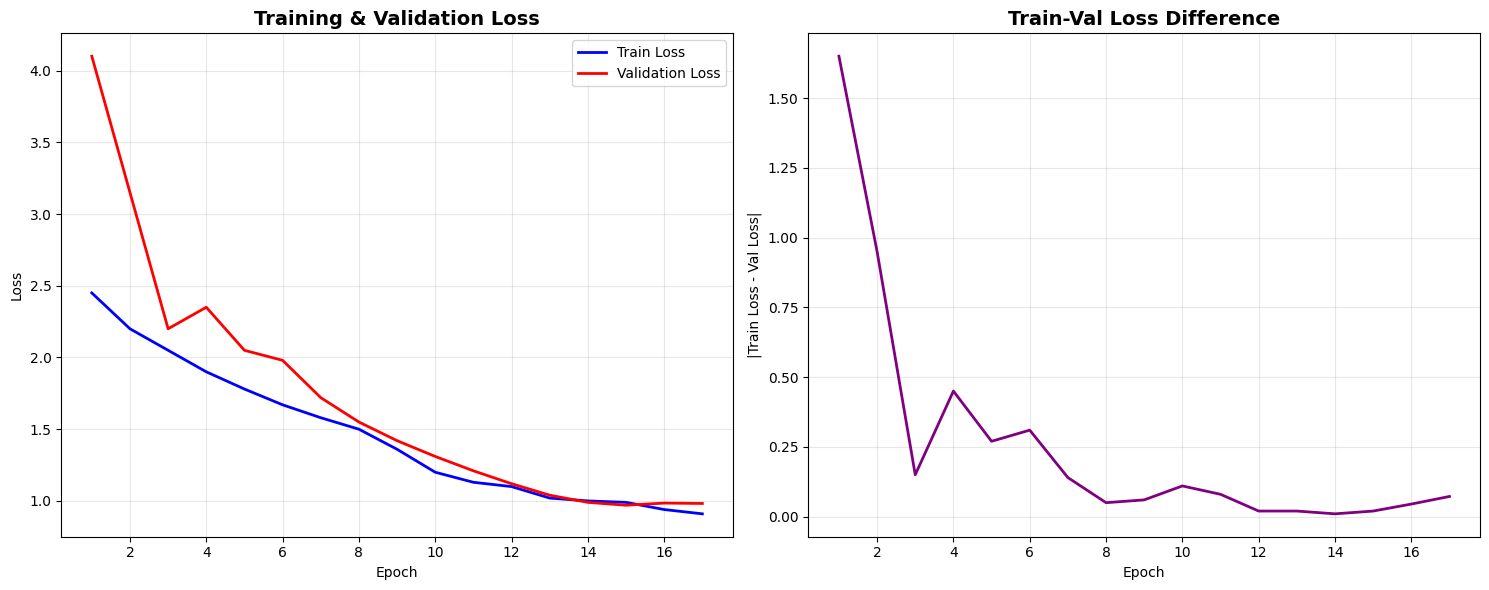


📈 TRAINING STATISTICS:
  • Total Epochs: 17
  • Best Validation Loss: 0.9700 (Epoch 15)
  • Final Train Loss: 0.9100
  • Final Val Loss: 0.9823
  • Mean Train-Val Difference: 0.2590


In [18]:
# Plot Training History từ training_info.json
print("📊 PLOTTING TRAINING HISTORY FROM SAVED DATA")
print("=" * 50)

output_dir = "./checkpoints"

# Load training history từ file
try:
    with open(os.path.join(output_dir, "training_info.json"), "r") as f:
        training_info = json.load(f)
    
    train_losses = training_info['train_losses']
    val_losses = training_info['val_losses']
    best_val_loss = training_info['best_val_loss']
    
    print(f"✅ Loaded training history: {len(train_losses)} epochs")
except FileNotFoundError:
    print("❌ training_info.json not found! Run training first.")
    train_losses = []
    val_losses = []

if train_losses and val_losses:
    # Tạo figure với subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Training và Validation Loss
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Loss Difference
    loss_diff = [abs(t - v) for t, v in zip(train_losses, val_losses)]
    ax2.plot(epochs, loss_diff, 'purple', linewidth=2)
    ax2.set_title('Train-Val Loss Difference', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('|Train Loss - Val Loss|')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, "training_history_plot.png"), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(output_dir, "training_history.png"), dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"\n📈 TRAINING STATISTICS:")
    print(f"  • Total Epochs: {len(train_losses)}")
    print(f"  • Best Validation Loss: {min(val_losses):.4f} (Epoch {best_epoch})")
    print(f"  • Final Train Loss: {train_losses[-1]:.4f}")
    print(f"  • Final Val Loss: {val_losses[-1]:.4f}")
    print(f"  • Mean Train-Val Difference: {mean_diff:.4f}")

    stats = {
        "total_epochs": len(train_losses),
        "best_val_loss": float(min(val_losses)),
        "best_epoch": int(best_epoch),
        "final_train_loss": float(train_losses[-1]),
        "final_val_loss": float(val_losses[-1]),
        "mean_train_val_diff": float(mean_diff),
        "train_loss_trend": "decreasing" if train_losses[-1] < train_losses[0] else "increasing",
        "val_loss_trend": "decreasing" if val_losses[-1] < val_losses[0] else "increasing"
    }

    with open(os.path.join(output_dir, "training_statistics.json"), "w") as f:
        json.dump(stats, f, indent=2)